In [1]:
# Importing the Required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn import svm
from random import shuffle
from tqdm import tqdm_notebook as tqdm

In [2]:
cam = cv2.VideoCapture(0,cv2.CAP_DSHOW) 
cam_width =  cam.get(3)
cam_height = cam.get(4)

asl_img = cv2.imread('Media/M4/asl22.png')
asl_img = cv2.resize(asl_img, (int(cam_width), int(cam_height)))
cam.release()

In [59]:
# Path for our training data, you can change this to `custom_testing` for storing test data.
training_path = 'Media/M5/custom_training_own'
# Initialize the Webcam
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW) 

# Create a named window
cv2.namedWindow("Train the Samples")

# Create a Counter
img_counter = 0

# Define all the Classes you want to classify with a space.
classes_string = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'

# Now we will store each class seperately
classes = classes_string.split(' ')

# We are storing the ASCII values of all the letters in a new list. 
asci_values = [ord(item) for item in classes]

# These are all the special characters, Note: nothing asci value 9 is from the tab button.
special_case = [('nothing', 0)]

# Append the special values with their asci values.
for char, asci in special_case:
    asci_values.append(asci)
    classes.append(char)

#Initializing storage
storage = None

# Variable deciding whether to override previous saved samples
override = False

while True:
    
    ret, frame = cam.read()  
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)
    
    # Taking ascii value of input key from user
    k = cv2.waitKey(1)
    
    # Check to make sure if the key that user pressed is among our classes
    if k in asci_values:
        
        # Now get the index of that class/letter from the ascii list.
        class_pos = asci_values.index(k)
        
        # Using the index get the associated class name/letter from the classes list.
        class_name = classes[class_pos].upper()
        
        # Extract the part of the frame where the hand is present
        image = frame[1:230,380:620]
        
        class_path = os.path.join(training_path, class_name)

        if not os.path.exists(class_path):
            os.mkdir(class_path)  
            
        # Reset the counter if you're now storing the samples of a different class.
        if storage != k:
            img_counter = 0
            
        # Adding samples vs Overriding them.
        if not override and img_counter == 0:
          if os.listdir(class_path):
            img_counter = max([int(img_name.replace(class_name,'').replace('.jpg','')) for img_name in os.listdir(class_path)])
            
        # Using the varibales above set up the image name.
        img_name = "{}{}.jpg".format(class_name, img_counter)

        # Save the image in folder named custom_training/<NAME_OF_CLASS>/  
        cv2.imwrite(os.path.join(training_path, '{}/{}'.format(class_name, img_name)), image)
        
        # Show the class name and the number of stored samples of the class
        cv2.putText(frame, "Class: {} , Sample Count: {}".format(class_name, img_counter), (10, 35),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        
        
        # Remember the class we're taking samples of.
        storage = k
        
        # Increment the counter for every new sample
        img_counter += 1
    
    # Exit if Esc is pressed.
    elif k == 27: 
        break
    
    # Draw a rectangle to show where to make the hand gestures.
    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    
    stacked = np.hstack((frame,asl_img))
    
    # Show the image
    cv2.imshow("Train the Samples", stacked)
    
cam.release()
cv2.destroyAllWindows()    

In [60]:
# The names of our image classes are the names of sub folders.
train_classes = [directory for directory in os.listdir(training_path) if os.path.isdir(os.path.join(training_path,directory))]
train_classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'NOTHING',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

Number of Samples in Class A: 55
Number of Samples in Class B: 55
Number of Samples in Class C: 54
Number of Samples in Class D: 54
Number of Samples in Class E: 56
Number of Samples in Class F: 54
Number of Samples in Class G: 55
Number of Samples in Class H: 55
Number of Samples in Class I: 55
Number of Samples in Class J: 54
Number of Samples in Class K: 58
Number of Samples in Class L: 56
Number of Samples in Class M: 58
Number of Samples in Class N: 57
Number of Samples in Class NOTHING: 87
Number of Samples in Class O: 57
Number of Samples in Class P: 58
Number of Samples in Class Q: 57
Number of Samples in Class R: 57
Number of Samples in Class S: 62
Number of Samples in Class T: 81
Number of Samples in Class U: 70
Number of Samples in Class V: 61
Number of Samples in Class W: 69
Number of Samples in Class X: 79
Number of Samples in Class Y: 75
Number of Samples in Class Z: 81


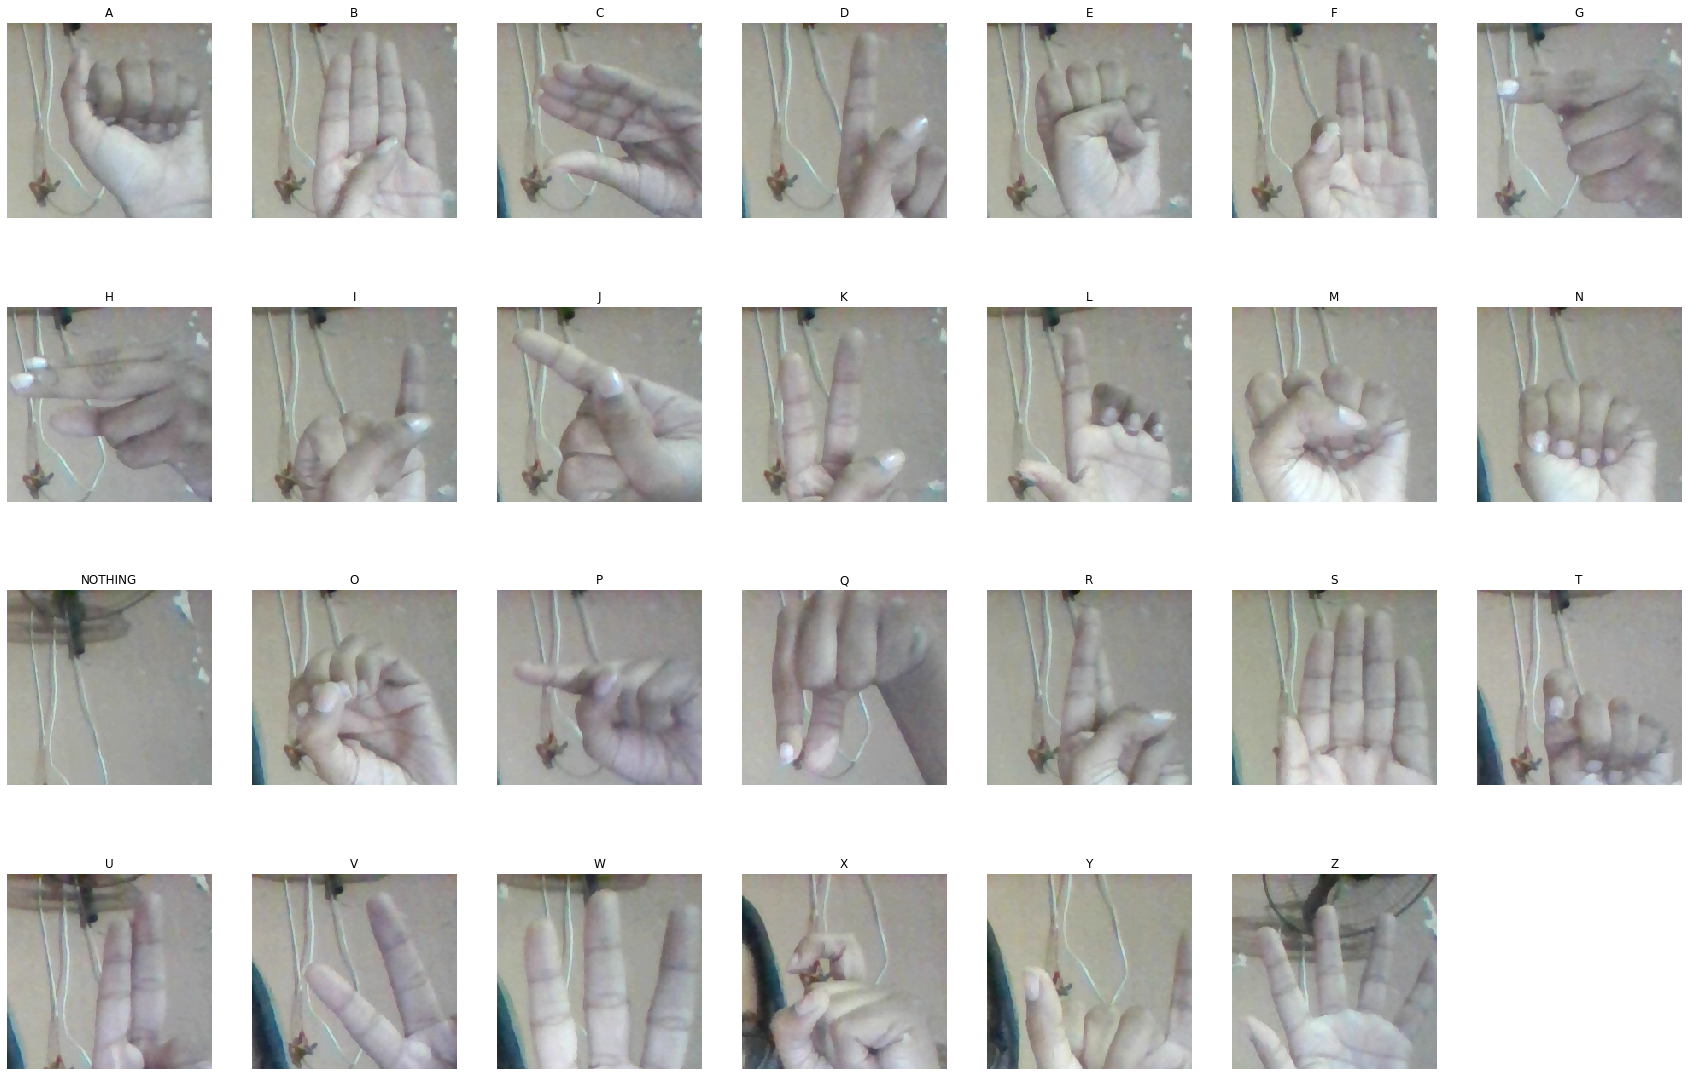

In [61]:
# Determine size, cols and rows for display
plt.figure(figsize=[30,20])
cols = 7
rows = int(np.ceil(len(train_classes)/cols))
Single_images_of_each_class = []

# Loop for each class
for i in range(len(train_classes)):
    
        # Take 1 image from each class
        name = os.listdir( os.path.join(training_path,train_classes[i]))[2]        
        print('Number of Samples in Class {}: {}'.format(train_classes[i], 
                                                         len(os.listdir( os.path.join(training_path,train_classes[i] )))))

        # Read and display image
        image = cv2.imread(os.path.join(training_path,train_classes[i],name))
        
        # Saving one image from each class for later use.
        Single_images_of_each_class.append((train_classes[i], image))
        
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.title(train_classes[i]);plt.axis('off');

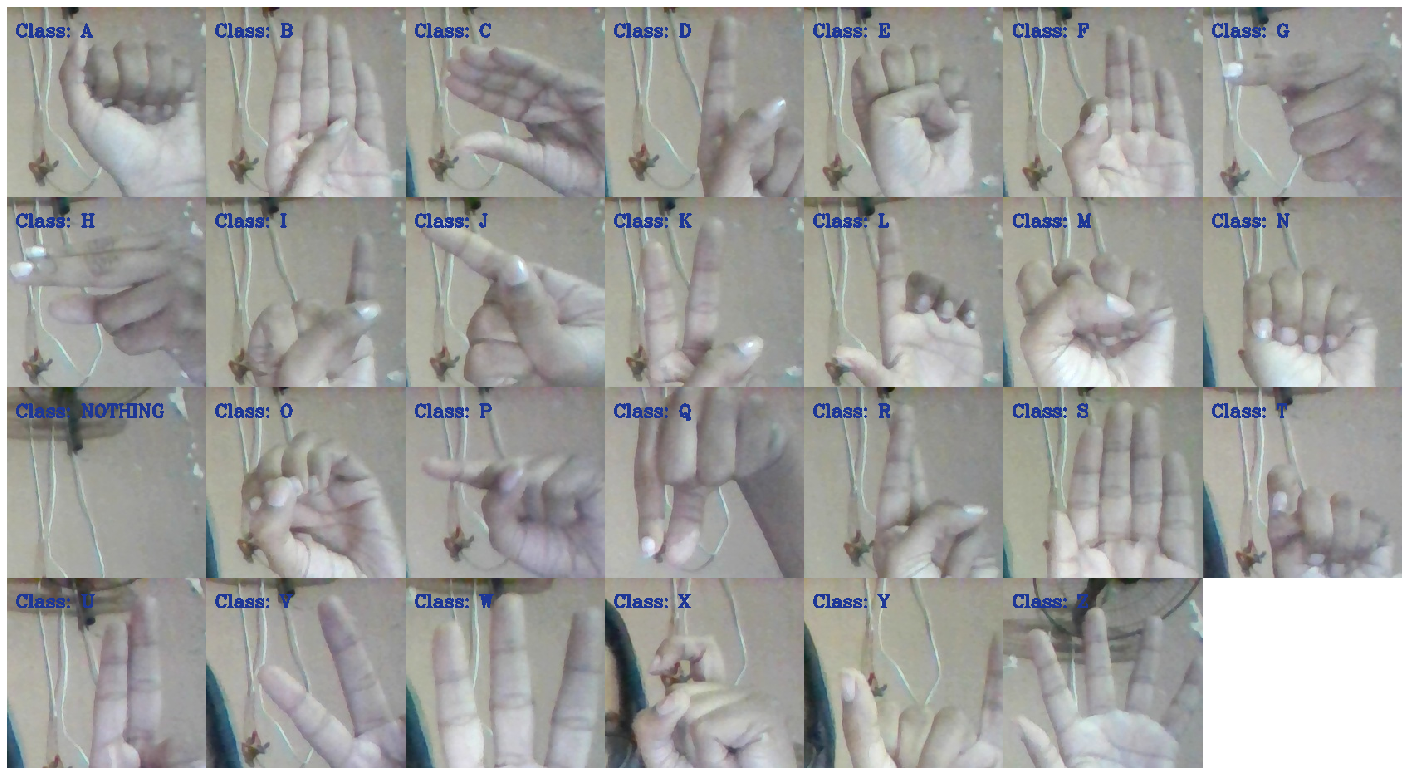

In [62]:
counter = 0

# Horizontal Stacking
stack = None

# Vertical Stacking
full_stack = None

# Number of Columns to use.
columns = 7

for class_name, img in Single_images_of_each_class:    
    
    # Put the class name on the image.
    cv2.putText(img, "Class: {}".format(class_name), (10, 35), cv2.FONT_HERSHEY_COMPLEX, 0.7, (150, 55, 30), 2)
    
    if stack is None:
        stack = img
    else:
        stack = np.hstack((stack,img))

    counter +=1
    
    if counter == columns:
        
          counter = 0
            
          if full_stack is None:
                full_stack = stack.copy()

          else:
                full_stack = np.vstack((full_stack, stack))                
          stack = None    
            
if columns - counter > 0 and counter !=  0:
    width = (columns - counter)  * img.shape[1]
    height = img.shape[0]
    fill_img = np.full((height, width, 3), 255, dtype='uint8')
    stackc = np.hstack((stack, fill_img))
    
    full_stack = np.vstack((full_stack, stackc))

plt.figure(figsize=[25,25])
plt.imshow(full_stack[:,:,::-1]);plt.axis('off');

# Finally resize this according to the dimensions of your camera.
full_stack = cv2.resize( full_stack, (int(cam_width), int(cam_height)))

In [63]:
# Define the percentage of data you want for the test set.
percentage = 10

for i in range(len(train_classes)):
    
    # Get the number of samples for each class
    length = len(os.listdir( os.path.join(training_path, train_classes[i] )))
    
    # Create a splitting point based on the percentage the user defined.
    splitter = round((length * percentage) / 100)
    
    # Print out the Training and Testing sample count of each class
    print('Total Samples in {}: {}, Train:{}, Test{}'.format(train_classes[i], length, (length-splitter), splitter))

# Create two dictionaries that will hold the training and test data
test_image_names  = {}
train_image_names = {}

# Now we will randomely shuffle our data and split between training and test data.
for i in range(len(train_classes)):
    
    # Get all the image names
    all_img_names = os.listdir(os.path.join(training_path, train_classes[i]))
    
    # Shuffle all the names
    shuffle(all_img_names)
    
    # Split the data
    train_image_names[train_classes[i]] =  all_img_names[splitter:]
    test_image_names[train_classes[i]]  =  all_img_names[:splitter]

Total Samples in A: 55, Train:49, Test6
Total Samples in B: 55, Train:49, Test6
Total Samples in C: 54, Train:49, Test5
Total Samples in D: 54, Train:49, Test5
Total Samples in E: 56, Train:50, Test6
Total Samples in F: 54, Train:49, Test5
Total Samples in G: 55, Train:49, Test6
Total Samples in H: 55, Train:49, Test6
Total Samples in I: 55, Train:49, Test6
Total Samples in J: 54, Train:49, Test5
Total Samples in K: 58, Train:52, Test6
Total Samples in L: 56, Train:50, Test6
Total Samples in M: 58, Train:52, Test6
Total Samples in N: 57, Train:51, Test6
Total Samples in NOTHING: 87, Train:78, Test9
Total Samples in O: 57, Train:51, Test6
Total Samples in P: 58, Train:52, Test6
Total Samples in Q: 57, Train:51, Test6
Total Samples in R: 57, Train:51, Test6
Total Samples in S: 62, Train:56, Test6
Total Samples in T: 81, Train:73, Test8
Total Samples in U: 70, Train:63, Test7
Total Samples in V: 61, Train:55, Test6
Total Samples in W: 69, Train:62, Test7
Total Samples in X: 79, Train:71, 

In [64]:
# Initialize hog parameters, I'm initializing with all the default values.
winSize = (120, 120) 
blockSize = (40, 40)
blockStride = (20, 20)
cellSize = (20, 20)
nbins = 9
derivAperture = 1 # has no effect 
winSigma = -1 # going to be equal to 4
histogramNormType = 1 # has no effect 
L2HysThreshold = 0.2
gammaCorrection = False
nlevels = 64 
signedGradient = False

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, 
                        L2HysThreshold, gammaCorrection, nlevels, signedGradient)

In [65]:
def getfeaturevectors(dictionary):
    # This list will hold the final feature vectors.
    Hog_feature_vectors = []

    # This list will hold the labels for each image.
    labels = []
    
    # This loop loops for each class (in total we have 29 classes for this dataset), we're also using tqdm for a progress bar.
    for classe_name in tqdm(list(dictionary.keys())):

            # This loop loops for each sample in each class (each class have approximately)
            for img_name in dictionary[classe_name]:

                # Read the image
                image = cv2.imread(os.path.join(training_path, classe_name, img_name))

                # Resize the image, if the image is corrupted then leave it 
                try:
                    image = cv2.resize(image, (120, 120))
                    
                except:
                    #print('Error Readimg image {}'.format(os.path.join(path,classes[i], j)))
                    continue

                # Compute the descriptor            
                descriptor = hog.compute(image)

                # Store the feature vector and the label
                Hog_feature_vectors.append(descriptor.reshape(-1))

                # Also store the label for each class
                labels.append(classe_name)

    print('Total Descriptors: {} and Total Labels: {}'.format(len(Hog_feature_vectors), len(labels) ))
    
    # Return the feature vectors with their labels.
    return Hog_feature_vectors, labels

In [66]:
hog_feature_vectors, labels = getfeaturevectors(train_image_names)

C:\Users\Sadaf Zehra\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Total Descriptors: 1454 and Total Labels: 1454


In [67]:
# Initializing SVM Model with rbf kernel 
model = svm.SVC(kernel='rbf', C = 30.0, gamma='scale')

In [68]:
%%time
model.fit(hog_feature_vectors, labels)
print("Training Completed")

Training Completed
Wall time: 931 ms


In [69]:
hog_feature_test_vectors, test_labels = getfeaturevectors(test_image_names)

C:\Users\Sadaf Zehra\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Total Descriptors: 216 and Total Labels: 216


In [70]:
score = model.score(hog_feature_test_vectors, test_labels)
print('Accuracy of Model is {:.2f}%'.format(score*100))

Accuracy of Model is 100.00%


In [71]:
#pickle.dump(model, open('Media/M5/own_asl.sav', 'wb'))
pickle.dump(model, open('Media/M5/own_asl1.sav', 'wb'))
# load the model from disk
#loaded_model = pickle.load(open('Media/M5/own_asl.sav', 'rb'))
loaded_model = pickle.load(open('Media/M5/own_asl1.sav', 'rb'))

In [90]:
# Read from camera
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW);
sentence = []
str1 = ""
c= 0
while (True):
    ret ,frame = cap.read()
    if not ret:
        break
        
    frame = cv2.flip(frame, 1)

    cv2.rectangle(frame, (383, 4), (638, 223), (255,0,0), 2)
    image = frame[1:230,380:620]
    
    # Resize the image as required.
    image = cv2.resize(image, (120, 120))
    
    # Compute the descriptor            
    descriptor = hog.compute(image)
    
    # Extract the label
    label = loaded_model.predict(descriptor.reshape(1,-1))[0]    
    
    # Put the label and show the results
    cv2.putText(frame, 'Prediction: {}'.format(label), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0,(100, 55, 200), 3)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('p'):
        sentence.append(label)        
    
    str1 = ""
    for i in sentence:
        str1+= i
    cv2.putText(frame, 'Sentence: {}'.format(str1), (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(100, 55, 200), 2)
    stacked = np.hstack((frame, full_stack))
    c+=1
    cv2.imshow("Results", stacked)
    
    #k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
    

cap.release()
cv2.destroyAllWindows()

In [91]:
sentence

['V', 'V', 'V', 'K', 'U', 'W', 'G', 'O', 'S']

In [92]:
str1

'VVVKUWGOS'

In [37]:
for i in 
for i in range(len(sentence)):
    